In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [0]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [0]:
print((features_vgg_train[0]))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.08144922e+01
 9.63409901e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.42899323e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.37654305e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.49597716e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.80448418e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.70643711e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [0]:
df = pd.read_csv("/content/drive/My Drive/youtube_project/small_total_train_set.csv", encoding='utf-8-sig')
y = df['category_id']
y = np.array(y)
y.shape

(13685,)

In [0]:
feature_self_cnn = pd.read_csv("/content/drive/My Drive/youtube_project/extracted_image_features_selfcnn.csv", index_col=0)
feature_self_cnn = np.array(feature_self_cnn)
feature_self_cnn.shape

(13685, 7200)

In [0]:
features_vgg_train = np.load('/content/drive/My Drive/youtube_project/extract_features_transfer_train.npy')
features_vgg_train.shape

(13685, 5120)

In [0]:
feature_fxt = np.load('/content/drive/My Drive/youtube_project/soy_fxt.npy')
feature_w2v = np.load('/content/drive/My Drive/youtube_project/soy_w2v.npy')
feature_fxt.shape, feature_w2v.shape

((13685, 100), (13685, 100))

### data split

In [0]:
case1_data = np.c_[features_vgg_train,feature_w2v]
nanmask = ~np.isnan(case1_data).any(axis=1)
case1_nan = case1_data[nanmask]
y_nan = y[nanmask]

In [0]:
train_idx = np.random.choice(case1_nan.shape[0], round(case1_nan.shape[0]*0.8), replace=False)

In [0]:
test_idx = np.setdiff1d(range(case1_nan.shape[0]), train_idx)

In [0]:
train_idx.shape, test_idx.shape

((10869,), (2717,))

In [0]:
def cbind_(imgdata,textdata) :
  data = np.c_[imgdata,textdata]
  nanmask = ~np.isnan(data).any(axis=1)
  x_data = data[nanmask]
  y_data = y[nanmask]
  return x_data,y_data

In [0]:
x_case1, y_case1 = cbind_(features_vgg_train,feature_w2v)
x_case2, y_case2 = cbind_(features_vgg_train,feature_fxt)
x_case3, y_case3 = cbind_(feature_self_cnn,feature_fxt)
x_case4, y_case4 = cbind_(feature_self_cnn,feature_w2v)

In [0]:
x_case1_model = x_case1[train_idx,:]
y_case1_model = y_case1[train_idx]

x_case2_model = x_case2[train_idx,:]
y_case2_model = y_case2[train_idx]

x_case3_model = x_case3[train_idx,:]
y_case3_model = y_case3[train_idx]

x_case4_model = x_case4[train_idx,:]
y_case4_model = y_case4[train_idx]

In [0]:
x_case1_test = x_case1[test_idx,:]
y_case1_test = y_case1[test_idx]

x_case2_test = x_case2[test_idx,:]
y_case2_test = y_case2[test_idx]

x_case3_test = x_case3[test_idx,:]
y_case3_test = y_case3[test_idx]

x_case4_test = x_case4[test_idx,:]
y_case4_test = y_case4[test_idx]

# Train

## 1. w2v + vgg

In [0]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[5220]),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(1024, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation="softmax")
])

model1.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [0]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_valid, y_train, y_valid = train_test_split(x_case1_model, y_case1_model)
X_train.shape, X_valid.shape
history = model1.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

# history = model1.fit(case1_nan, y_nan, epochs=30, validation_split=0.3)

Epoch 1/50
255/255 [==============================] - 4s 17ms/step - loss: 8.9670 - accuracy: 0.7616 - val_loss: 3.6074 - val_accuracy: 0.8249
Epoch 2/50
255/255 [==============================] - 4s 16ms/step - loss: 2.7837 - accuracy: 0.8087 - val_loss: 2.2621 - val_accuracy: 0.8304
Epoch 3/50
255/255 [==============================] - 4s 16ms/step - loss: 2.1535 - accuracy: 0.8087 - val_loss: 1.9734 - val_accuracy: 0.8337
Epoch 4/50
255/255 [==============================] - 4s 16ms/step - loss: 2.0330 - accuracy: 0.8008 - val_loss: 1.9165 - val_accuracy: 0.8190
Epoch 5/50
255/255 [==============================] - 4s 16ms/step - loss: 1.9675 - accuracy: 0.8033 - val_loss: 1.8071 - val_accuracy: 0.8469
Epoch 6/50
255/255 [==============================] - 4s 17ms/step - loss: 1.9376 - accuracy: 0.8054 - val_loss: 1.8941 - val_accuracy: 0.8164
Epoch 7/50
255/255 [==============================] - 4s 16ms/step - loss: 1.9877 - accuracy: 0.7999 - val_loss: 1.8999 - val_accuracy: 0.8289

In [0]:
X_train.shape, X_valid.shape

((8151, 5220), (2718, 5220))

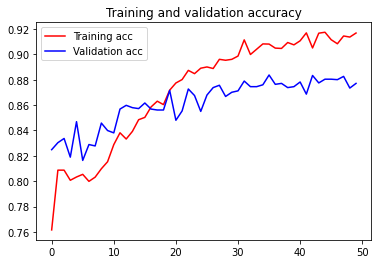

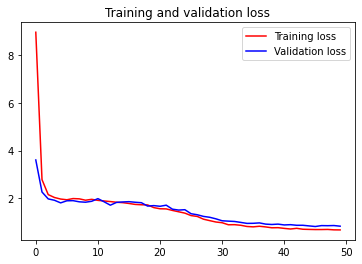

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2. fxt + vgg

In [0]:
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[5220]),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(1024, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation="softmax")
])

model2.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

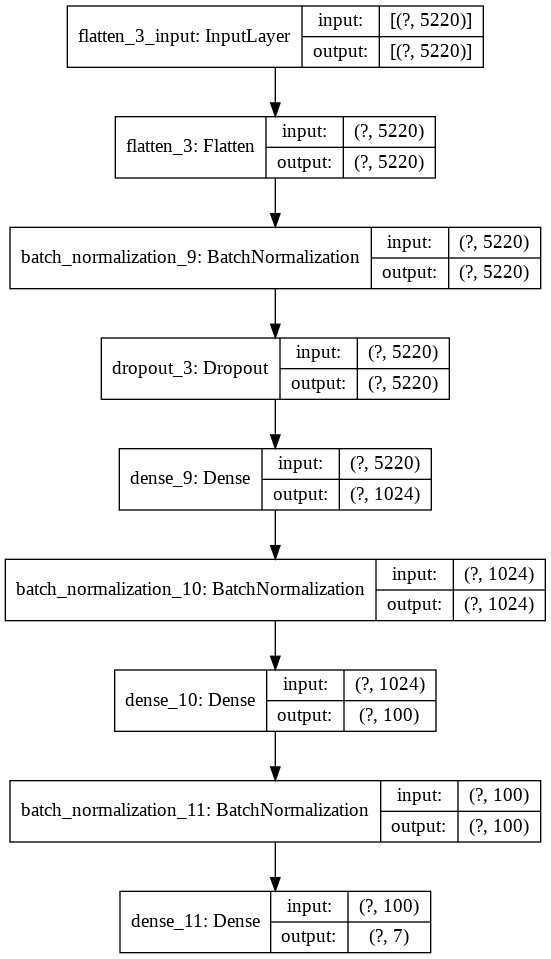

In [0]:
keras.utils.plot_model(model2, show_shapes=True)

In [0]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_valid, y_train, y_valid = train_test_split(x_case2_model, y_case2_model)
X_train.shape, X_valid.shape
history2 = model2.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
255/255 [==============================] - 4s 17ms/step - loss: 9.0978 - accuracy: 0.7777 - val_loss: 3.5765 - val_accuracy: 0.8451
Epoch 2/50
255/255 [==============================] - 4s 16ms/step - loss: 2.6999 - accuracy: 0.8242 - val_loss: 2.2348 - val_accuracy: 0.8267
Epoch 3/50
255/255 [==============================] - 4s 16ms/step - loss: 2.0936 - accuracy: 0.8243 - val_loss: 1.9466 - val_accuracy: 0.8466
Epoch 4/50
255/255 [==============================] - 4s 16ms/step - loss: 1.9404 - accuracy: 0.8200 - val_loss: 1.8996 - val_accuracy: 0.8488
Epoch 5/50
255/255 [==============================] - 4s 16ms/step - loss: 1.8820 - accuracy: 0.8195 - val_loss: 1.7900 - val_accuracy: 0.8344
Epoch 6/50
255/255 [==============================] - 4s 16ms/step - loss: 1.9237 - accuracy: 0.8140 - val_loss: 1.8872 - val_accuracy: 0.8381
Epoch 7/50
255/255 [==============================] - 4s 16ms/step - loss: 1.8709 - accuracy: 0.8233 - val_loss: 1.7380 - val_accuracy: 0.8550

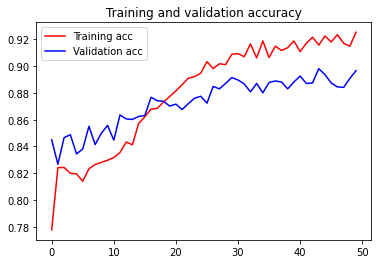

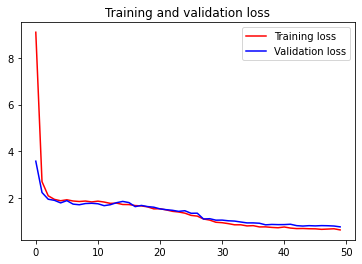

In [0]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 3. fxt + cnn

In [0]:
model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[7300]),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(1024, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation="softmax")
])

model3.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

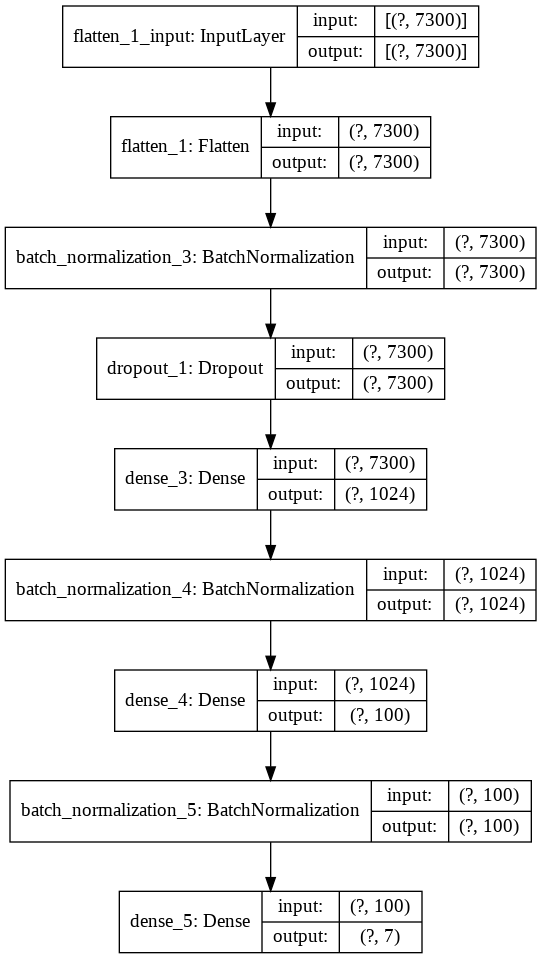

In [0]:
keras.utils.plot_model(model3, show_shapes=True)

In [0]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_valid, y_train, y_valid = train_test_split(x_case3_model, y_case3_model)
X_train.shape, X_valid.shape

((8151, 7300), (2718, 7300))

In [0]:
history3 = model3.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
255/255 [==============================] - 5s 21ms/step - loss: 7.8634 - accuracy: 0.6987 - val_loss: 2.7356 - val_accuracy: 0.7108
Epoch 2/50
255/255 [==============================] - 5s 20ms/step - loss: 2.3071 - accuracy: 0.7348 - val_loss: 1.9875 - val_accuracy: 0.7781
Epoch 3/50
255/255 [==============================] - 5s 20ms/step - loss: 1.9396 - accuracy: 0.7424 - val_loss: 1.8941 - val_accuracy: 0.7561
Epoch 4/50
255/255 [==============================] - 5s 20ms/step - loss: 1.9105 - accuracy: 0.7430 - val_loss: 1.6776 - val_accuracy: 0.8006
Epoch 5/50
255/255 [==============================] - 5s 20ms/step - loss: 1.8313 - accuracy: 0.7417 - val_loss: 1.7157 - val_accuracy: 0.7785
Epoch 6/50
255/255 [==============================] - 5s 20ms/step - loss: 1.7798 - accuracy: 0.7497 - val_loss: 1.6840 - val_accuracy: 0.7896
Epoch 7/50
255/255 [==============================] - 5s 20ms/step - loss: 1.7496 - accuracy: 0.7579 - val_loss: 1.7062 - val_accuracy: 0.7583

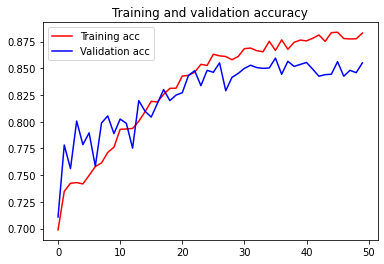

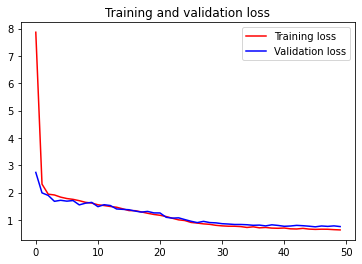

In [0]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 4. w2v + cnn

In [0]:
model4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[7300]),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(1024, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu",
                         kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation="softmax")
])

model4.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [0]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
X_train, X_valid, y_train, y_valid = train_test_split(x_case4_model, y_case4_model)
X_train.shape, X_valid.shape
history4 = model4.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
255/255 [==============================] - 5s 21ms/step - loss: 7.6751 - accuracy: 0.6805 - val_loss: 2.7012 - val_accuracy: 0.6976
Epoch 2/50
255/255 [==============================] - 5s 20ms/step - loss: 2.3024 - accuracy: 0.7154 - val_loss: 2.0736 - val_accuracy: 0.7116
Epoch 3/50
255/255 [==============================] - 5s 20ms/step - loss: 2.0006 - accuracy: 0.7135 - val_loss: 1.8613 - val_accuracy: 0.7561
Epoch 4/50
255/255 [==============================] - 5s 20ms/step - loss: 1.9812 - accuracy: 0.7164 - val_loss: 2.0239 - val_accuracy: 0.7189
Epoch 5/50
255/255 [==============================] - 5s 20ms/step - loss: 1.9324 - accuracy: 0.7303 - val_loss: 1.8111 - val_accuracy: 0.7520
Epoch 6/50
255/255 [==============================] - 5s 20ms/step - loss: 1.8745 - accuracy: 0.7339 - val_loss: 1.7784 - val_accuracy: 0.7520
Epoch 7/50
255/255 [==============================] - 5s 20ms/step - loss: 1.8050 - accuracy: 0.7400 - val_loss: 1.7753 - val_accuracy: 0.7520

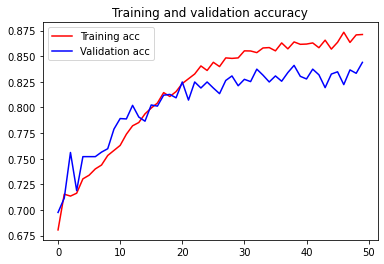

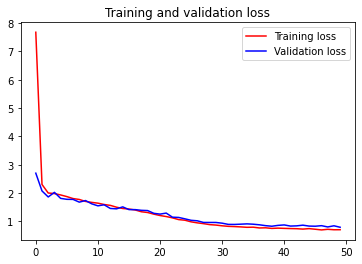

In [0]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Test** 

In [0]:
score1 = model1.evaluate(x_case1_test, y_case1_test)
score2 = model2.evaluate(x_case2_test, y_case2_test)
score3 = model3.evaluate(x_case3_test, y_case3_test)
score4 = model4.evaluate(x_case4_test, y_case4_test)

85/85 [==============================] - 0s 4ms/step - loss: 0.8205 - accuracy: 0.8370


In [0]:
pred_ = np.argmax(model2.predict(x_case2_test), axis=-1)


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix( y_case2_test,pred_,)

# labels=["cooking", "economy", "game","movie","pets","politics","sports"]

array([[346,   1,  12,   7,   2,   1,   3],
       [  1, 333,   5,   0,   1,  11,   3],
       [  4,   3, 317,   9,   3,  12,  26],
       [  1,   0,  18,  60,   6,   6,  10],
       [ 16,   0,  12,   8, 358,   0,   8],
       [  5,   3,  11,   5,   3, 683,  10],
       [  7,   1,  37,   8,   7,  20, 314]])

In [0]:
y_true = pd.Series(y_case2_test)
y_pred = pd.Series(pred_)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'])



Predicted,0,1,2,3,4,5,6
True,,,,,,,
0,346,1,12,7,2,1,3
1,1,333,5,0,1,11,3
2,4,3,317,9,3,12,26
3,1,0,18,60,6,6,10
4,16,0,12,8,358,0,8
5,5,3,11,5,3,683,10
6,7,1,37,8,7,20,314
